In [6]:
from pathlib import Path
import yaml

data = {
    "path": "/kaggle/input/boomers-knife-detection",
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": 1,
    "names": ["Knife"]
}

out_path = Path("/kaggle/working/data.yaml")

with open(out_path, "w") as f:
    yaml.dump(data, f, sort_keys=False)

print("Correct data.yaml written to:", out_path)


Correct data.yaml written to: /kaggle/working/data.yaml


In [7]:
from pathlib import Path

BASE_PATH = Path("/kaggle/input/boomers-knife-detection")

def count_files(split):
    images = list((BASE_PATH / split / "images").glob("*"))
    labels = list((BASE_PATH / split / "labels").glob("*"))
    return len(images), len(labels)

splits = ["train", "val", "test"]

total_images = 0
total_labels = 0

print("DATASET SIZE REPORT")
print("-" * 30)

for split in splits:
    img_count, lbl_count = count_files(split)
    total_images += img_count
    total_labels += lbl_count
    
    print(f"{split.upper():<5} -> Images: {img_count:>5} | Labels: {lbl_count:>5}")

print("-" * 30)
print(f"TOTAL -> Images: {total_images} | Labels: {total_labels}")


DATASET SIZE REPORT
------------------------------
TRAIN -> Images:  7351 | Labels:  7351
VAL   -> Images:   918 | Labels:   918
TEST  -> Images:   920 | Labels:   920
------------------------------
TOTAL -> Images: 9189 | Labels: 9189


## Install + environment checks

In [8]:
!pip -q install --upgrade ultralytics

import os, re, time, json, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from ultralytics import YOLO

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

# Reproducibility (best-effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


torch: 2.8.0+cu126
cuda available: True
gpu: Tesla T4


## Dataset paths + build a robust data.yaml

In [9]:
DATASET_ROOT = Path("/kaggle/input/boomers-knife-detection")
assert DATASET_ROOT.exists(), f"Dataset root not found: {DATASET_ROOT}"

TRAIN_IMG_DIR = DATASET_ROOT / "train" / "images"
TRAIN_LBL_DIR = DATASET_ROOT / "train" / "labels"
VAL_IMG_DIR   = DATASET_ROOT / "val"   / "images"
VAL_LBL_DIR   = DATASET_ROOT / "val"   / "labels"
TEST_IMG_DIR  = DATASET_ROOT / "test"  / "images"
TEST_LBL_DIR  = DATASET_ROOT / "test"  / "labels"

for p in [TRAIN_IMG_DIR, TRAIN_LBL_DIR, VAL_IMG_DIR, VAL_LBL_DIR, TEST_IMG_DIR, TEST_LBL_DIR]:
    assert p.exists(), f"Missing path: {p}"

def count_images(img_dir: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    return sum(1 for f in img_dir.iterdir() if f.suffix.lower() in exts)

def infer_num_classes_from_labels(lbl_dir: Path, max_files: int = 2000) -> int:
    lbl_files = list(lbl_dir.glob("*.txt"))
    if not lbl_files:
        raise RuntimeError(f"No label files found in: {lbl_dir}")
    random.shuffle(lbl_files)
    lbl_files = lbl_files[:min(len(lbl_files), max_files)]

    max_cls = -1
    for lf in lbl_files:
        txt = lf.read_text().strip()
        if not txt:
            continue
        for line in txt.splitlines():
            parts = line.strip().split()
            if not parts:
                continue
            # YOLO label: cls x y w h
            try:
                c = int(float(parts[0]))
                max_cls = max(max_cls, c)
            except:
                pass
    if max_cls < 0:
        raise RuntimeError("Could not infer classes (labels empty/unreadable).")
    return max_cls + 1

train_imgs = count_images(TRAIN_IMG_DIR)
val_imgs   = count_images(VAL_IMG_DIR)
test_imgs  = count_images(TEST_IMG_DIR)

nc = infer_num_classes_from_labels(TRAIN_LBL_DIR)
names = [f"class{i}" for i in range(nc)]  # names not required for training correctness, but yaml needs it

print("DATASET SIZE REPORT")
print("-"*30)
print(f"TRAIN -> Images: {train_imgs}")
print(f"VAL   -> Images: {val_imgs}")
print(f"TEST  -> Images: {test_imgs}")
print("-"*30)
print(f"TOTAL -> Images: {train_imgs + val_imgs + test_imgs}")
print(f"Inferred nc: {nc}")

# Write yaml into /kaggle/working
DATA_YAML_PATH = Path("/kaggle/working/data.yaml")
yaml_text = f"""# Auto-generated for Kaggle
path: {DATASET_ROOT}
train: train/images
val: val/images
test: test/images

nc: {nc}
names: {names}
"""
DATA_YAML_PATH.write_text(yaml_text)
print(f"Wrote: {DATA_YAML_PATH}")
print(DATA_YAML_PATH.read_text())


DATASET SIZE REPORT
------------------------------
TRAIN -> Images: 7351
VAL   -> Images: 918
TEST  -> Images: 920
------------------------------
TOTAL -> Images: 9189
Inferred nc: 1
Wrote: /kaggle/working/data.yaml
# Auto-generated for Kaggle
path: /kaggle/input/boomers-knife-detection
train: train/images
val: val/images
test: test/images

nc: 1
names: ['class0']



##   settings + select the best combo  

In [10]:
settings = [
    {"imgsz": 640, "lr0": 0.01,  "batch": 16, "augment": True},
    {"imgsz": 640, "lr0": 0.005, "batch": 16, "augment": True},
    {"imgsz": 512, "lr0": 0.01,  "batch": 32, "augment": True},  # BEST (per your results)
    {"imgsz": 736, "lr0": 0.01,  "batch": 16, "augment": True},
    {"imgsz": 640, "lr0": 0.02,  "batch": 16, "augment": False},
]

models = {
    "YOLOv8s":  "yolov8s.pt",
    "YOLOv11s": "yolo11s.pt"
}

BEST_SETTING_IDX = 2
BEST_CFG = settings[BEST_SETTING_IDX].copy()
BEST_CFG


{'imgsz': 512, 'lr0': 0.01, 'batch': 32, 'augment': True}

## Plot learning curves (train/val vs epochs) for each architecture

In [11]:
RUNS_DIR = Path("/kaggle/working/runs_final")
FIG_DIR  = Path("/kaggle/working/figures_final")
RUNS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# You can adjust these if you already know your best epoch behavior.
EPOCHS_MAIN = 60
PATIENCE = 15
WORKERS = 2  # Kaggle often works best with small worker count

def train_best(model_key: str, weights: str, cfg: dict):
    exp_name = f"{model_key}_BEST_img{cfg['imgsz']}_lr{cfg['lr0']}_bs{cfg['batch']}_aug{int(cfg['augment'])}"
    print("Experiment:", exp_name)

    y = YOLO(weights)
    t0 = time.time()
    results = y.train(
        data=str(DATA_YAML_PATH),
        imgsz=cfg["imgsz"],
        lr0=cfg["lr0"],
        batch=cfg["batch"],
        augment=cfg["augment"],
        epochs=EPOCHS_MAIN,
        patience=PATIENCE,
        device=0 if torch.cuda.is_available() else "cpu",
        workers=WORKERS,
        project=str(RUNS_DIR),
        name=exp_name,
        exist_ok=True,
        verbose=False,
        plots=True,   # ultralytics will also output default plots
        cache=False   # set True if you want speed at the cost of RAM
    )
    minutes = (time.time() - t0) / 60.0
    save_dir = Path(results.save_dir)
    print(f"Done: {model_key} | time(min)={minutes:.2f} | save_dir={save_dir}")
    return {"model": model_key, "save_dir": str(save_dir), "train_time_min": minutes}

run_meta = []
for k, w in models.items():
    run_meta.append(train_best(k, w, BEST_CFG))

run_meta_df = pd.DataFrame(run_meta)
run_meta_df


Experiment: YOLOv8s_BEST_img512_lr0.01_bs32_aug1
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv8s_BEST_img512_lr0.01_bs32_aug1, nbs=64, nms=False, opset=None, optimize=False, optimizer=au

,model,save_dir,train_time_min
0,YOLOv8s,/kaggle/working/runs_final/YOLOv8s_BEST_img512...,82.519100
1,YOLOv11s,/kaggle/working/runs_final/YOLOv11s_BEST_img51...,85.831345


## Identify best architecture and run dataset-size curve

In [12]:
# Pick best architecture based on your  results
BEST_ARCH = "YOLOv11s"
BEST_WEIGHTS = models[BEST_ARCH]

SIZE_FRACTIONS = [0.10, 0.25, 0.50, 0.75, 1.00]

# Keep this smaller than the main run to control total runtime.
EPOCHS_SIZE = 30
PATIENCE_SIZE = 10

SUBSET_DIR = Path("/kaggle/working/subsets")
SUBSET_DIR.mkdir(parents=True, exist_ok=True)

def list_images(img_dir: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    imgs = [str(p) for p in img_dir.iterdir() if p.suffix.lower() in exts]
    imgs.sort()
    return imgs

all_train_images = list_images(TRAIN_IMG_DIR)
n_total = len(all_train_images)
print("Total train images:", n_total)

def write_subset_train_list(frac: float) -> Path:
    n = max(1, int(round(n_total * frac)))
    rng = np.random.default_rng(SEED + int(frac * 1000))
    idx = rng.choice(n_total, size=n, replace=False)
    subset_imgs = [all_train_images[i] for i in idx]
    subset_txt = SUBSET_DIR / f"train_frac_{int(frac*100):03d}.txt"
    subset_txt.write_text("\n".join(subset_imgs) + "\n")
    return subset_txt

def write_subset_yaml(train_list_txt: Path) -> Path:
    # Ultralytics accepts .txt list for train
    frac_tag = train_list_txt.stem.replace("train_frac_", "")
    ypath = SUBSET_DIR / f"data_frac_{frac_tag}.yaml"
    ytext = f"""# Auto-generated subset yaml
path: {DATASET_ROOT}
train: {train_list_txt}
val: val/images
test: test/images

nc: {nc}
names: {names}
"""
    ypath.write_text(ytext)
    return ypath

def extract_metrics(val_results):
    """
    Ultralytics returns an object; we'll try robust access.
    """
    d = {}
    # preferred: results_dict
    if hasattr(val_results, "results_dict") and isinstance(val_results.results_dict, dict):
        rd = val_results.results_dict
        for k in rd:
            d[k] = float(rd[k]) if isinstance(rd[k], (int, float, np.number)) else rd[k]
        return d

    # fallback: try box metrics
    if hasattr(val_results, "box"):
        box = val_results.box
        for attr in ["map50", "map", "mp", "mr"]:
            if hasattr(box, attr):
                d[attr] = float(getattr(box, attr))
    return d

size_rows = []

for frac in SIZE_FRACTIONS:
    train_list = write_subset_train_list(frac)
    sub_yaml = write_subset_yaml(train_list)

    exp_name = f"{BEST_ARCH}_SIZE_frac{int(frac*100):03d}_img{BEST_CFG['imgsz']}_lr{BEST_CFG['lr0']}_bs{BEST_CFG['batch']}"
    print("\n====", exp_name, "====")

    y = YOLO(BEST_WEIGHTS)

    t0 = time.time()
    train_res = y.train(
        data=str(sub_yaml),
        imgsz=BEST_CFG["imgsz"],
        lr0=BEST_CFG["lr0"],
        batch=BEST_CFG["batch"],
        augment=BEST_CFG["augment"],
        epochs=EPOCHS_SIZE,
        patience=PATIENCE_SIZE,
        device=0 if torch.cuda.is_available() else "cpu",
        workers=WORKERS,
        project=str(RUNS_DIR),
        name=exp_name,
        exist_ok=True,
        verbose=False,
        plots=False
    )
    train_time_min = (time.time() - t0)/60.0
    save_dir = Path(train_res.save_dir)

    best_pt = save_dir / "weights" / "best.pt"
    assert best_pt.exists(), f"best.pt not found: {best_pt}"

    # Evaluate on TRAIN split and VAL split (to satisfy "training and validation performance vs dataset size")
    y_best = YOLO(str(best_pt))

    # Validation metrics
    val_out = y_best.val(data=str(sub_yaml), split="val", imgsz=BEST_CFG["imgsz"], device=0 if torch.cuda.is_available() else "cpu", verbose=False)
    val_metrics = extract_metrics(val_out)

    # Train metrics (some versions support split='train'; if not, fallback to 'val' on train list)
    train_metrics = {}
    try:
        tr_out = y_best.val(data=str(sub_yaml), split="train", imgsz=BEST_CFG["imgsz"], device=0 if torch.cuda.is_available() else "cpu", verbose=False)
        train_metrics = extract_metrics(tr_out)
    except Exception as e:
        print("train-split val() not supported in this ultralytics version; fallback to empty train metrics.")
        train_metrics = {}

    size_rows.append({
        "arch": BEST_ARCH,
        "fraction": frac,
        "n_train_images": int(round(n_total * frac)),
        "train_time_min": train_time_min,
        # Common keys (Ultralytics varies; we store everything we can)
        "val_map50": val_metrics.get("metrics/mAP50(B)", val_metrics.get("map50", np.nan)),
        "val_map5095": val_metrics.get("metrics/mAP50-95(B)", val_metrics.get("map", np.nan)),
        "val_precision": val_metrics.get("metrics/precision(B)", val_metrics.get("mp", np.nan)),
        "val_recall": val_metrics.get("metrics/recall(B)", val_metrics.get("mr", np.nan)),
        "train_map50": train_metrics.get("metrics/mAP50(B)", train_metrics.get("map50", np.nan)),
        "train_map5095": train_metrics.get("metrics/mAP50-95(B)", train_metrics.get("map", np.nan)),
        "save_dir": str(save_dir),
    })

size_df = pd.DataFrame(size_rows).sort_values("n_train_images").reset_index(drop=True)
size_df


Total train images: 7351

==== YOLOv11s_SIZE_frac010_img512_lr0.01_bs32 ====
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/subsets/data_frac_010.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv11s_SIZE_frac010_img512_lr0.01_bs32, nbs=64, nm

,arch,fraction,n_train_images,train_time_min,val_map50,val_map5095,val_precision,val_recall,train_map50,train_map5095,save_dir
0,YOLOv11s,0.10,735,7.568736,0.652432,0.310941,0.672356,0.632871,0.874095,0.516424,/kaggle/working/runs_final/YOLOv11s_SIZE_frac0...
1,YOLOv11s,0.25,1838,13.494198,0.788238,0.432757,0.766048,0.733854,0.911450,0.581297,/kaggle/working/runs_final/YOLOv11s_SIZE_frac0...
2,YOLOv11s,0.50,3676,23.306659,0.847630,0.504578,0.807564,0.798292,0.926777,0.629267,/kaggle/working/runs_final/YOLOv11s_SIZE_frac0...
3,YOLOv11s,0.75,5513,33.197540,0.871027,0.541689,0.850739,0.839915,0.933998,0.657179,/kaggle/working/runs_final/YOLOv11s_SIZE_frac0...
4,YOLOv11s,1.00,7351,42.831394,0.888025,0.576826,0.847189,0.846099,0.944329,0.675446,/kaggle/working/runs_final/YOLOv11s_SIZE_frac1...


## Plot performance vs dataset size (train & val)

Saved: /kaggle/working/dataset_size_results.csv


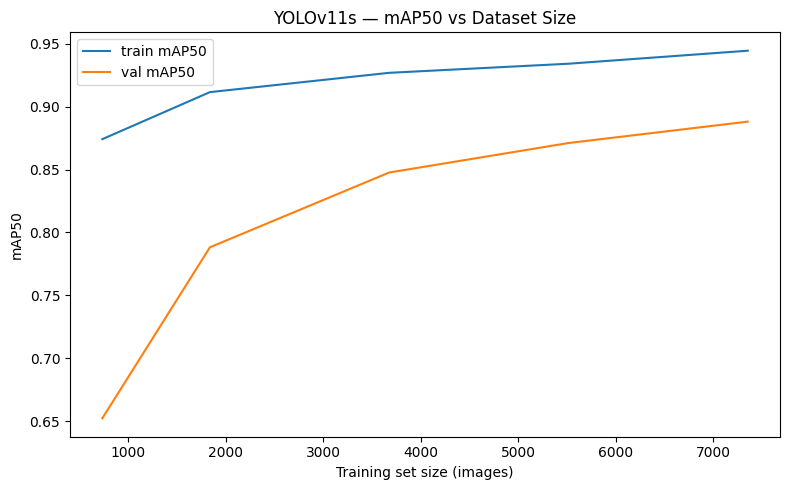

Saved: /kaggle/working/figures_final/YOLOv11s_map50_vs_dataset_size.png


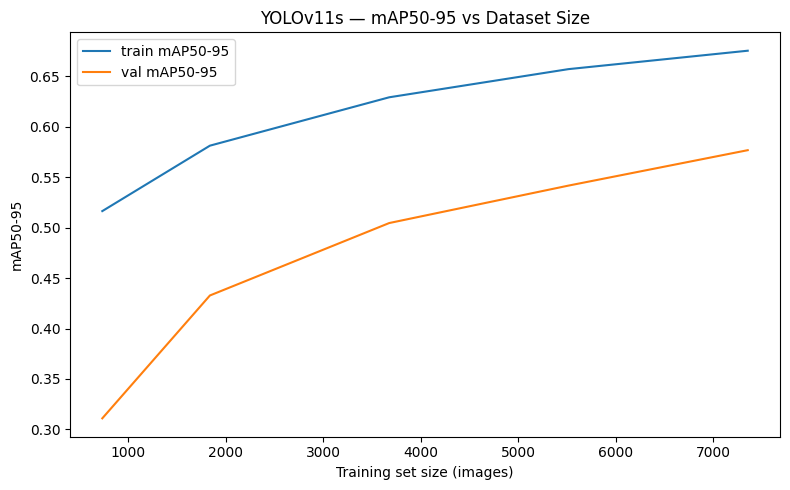

Saved: /kaggle/working/figures_final/YOLOv11s_map5095_vs_dataset_size.png


In [13]:
# Save table for report
csv_out = Path("/kaggle/working/dataset_size_results.csv")
size_df.to_csv(csv_out, index=False)
print("Saved:", csv_out)

x = size_df["n_train_images"].values

# Plot mAP50 vs dataset size (train & val)
plt.figure(figsize=(8,5))
plt.plot(x, size_df["train_map50"].values, label="train mAP50")
plt.plot(x, size_df["val_map50"].values, label="val mAP50")
plt.xlabel("Training set size (images)")
plt.ylabel("mAP50")
plt.title(f"{BEST_ARCH} — mAP50 vs Dataset Size")
plt.legend()
out = FIG_DIR / f"{BEST_ARCH}_map50_vs_dataset_size.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

# Plot mAP50-95 vs dataset size (train & val)
plt.figure(figsize=(8,5))
plt.plot(x, size_df["train_map5095"].values, label="train mAP50-95")
plt.plot(x, size_df["val_map5095"].values, label="val mAP50-95")
plt.xlabel("Training set size (images)")
plt.ylabel("mAP50-95")
plt.title(f"{BEST_ARCH} — mAP50-95 vs Dataset Size")
plt.legend()
out = FIG_DIR / f"{BEST_ARCH}_map5095_vs_dataset_size.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)


## Final test-set evaluation for best model

In [14]:
# Find YOLOv8s best.pt and YOLOv11s best.pt from the main runs
def best_pt_from_save_dir(save_dir: str) -> Path:
    p = Path(save_dir) / "weights" / "best.pt"
    assert p.exists(), f"Missing: {p}"
    return p

main_runs = {r["model"]: Path(r["save_dir"]) for r in run_meta}

test_rows = []
for model_key in ["YOLOv8s", "YOLOv11s"]:
    best_pt = best_pt_from_save_dir(str(main_runs[model_key]))
    y = YOLO(str(best_pt))

    out = y.val(
        data=str(DATA_YAML_PATH),
        split="test",
        imgsz=BEST_CFG["imgsz"],
        device=0 if torch.cuda.is_available() else "cpu",
        verbose=False
    )
    met = extract_metrics(out)

    test_rows.append({
        "architecture": model_key,
        "best_setting_idx": BEST_SETTING_IDX,
        "imgsz": BEST_CFG["imgsz"],
        "lr0": BEST_CFG["lr0"],
        "batch": BEST_CFG["batch"],
        "augment": BEST_CFG["augment"],
        "test_map50": met.get("metrics/mAP50(B)", met.get("map50", np.nan)),
        "test_map5095": met.get("metrics/mAP50-95(B)", met.get("map", np.nan)),
        "test_precision": met.get("metrics/precision(B)", met.get("mp", np.nan)),
        "test_recall": met.get("metrics/recall(B)", met.get("mr", np.nan)),
        "weights_path": str(best_pt),
    })

test_df = pd.DataFrame(test_rows)
test_df.to_csv("/kaggle/working/test_results_best_models.csv", index=False)
test_df


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 3.5±6.1 ms, read: 4.0±0.8 MB/s, size: 29.4 KB)
val: Scanning /kaggle/input/boomers-knife-detection/test/labels... 920 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 920/920 148.8it/s 6.2s<0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/boomers-knife-detection/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 58/58 5.7it/s 10.2s0.2s
                   all        920        941      0.876      0.873      0.902      0.623
Speed: 0.7ms preprocess, 6.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/val11
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 

,architecture,best_setting_idx,imgsz,lr0,batch,augment,test_map50,test_map5095,test_precision,test_recall,weights_path
0,YOLOv8s,2,512,0.01,32,True,0.901869,0.623022,0.876313,0.873382,/kaggle/working/runs_final/YOLOv8s_BEST_img512...
1,YOLOv11s,2,512,0.01,32,True,0.906612,0.618522,0.866690,0.870525,/kaggle/working/runs_final/YOLOv11s_BEST_img51...


In [15]:
import shutil
from pathlib import Path

# Source and output paths
source_dir = Path("/kaggle/working")
zip_path = Path("/kaggle/working/working_backup")

# Remove existing zip if it exists
if zip_path.with_suffix(".zip").exists():
    zip_path.with_suffix(".zip").unlink()

# Create zip archive
shutil.make_archive(
    base_name=str(zip_path),
    format="zip",
    root_dir=str(source_dir)
)

print("Zip file created at:")
print(zip_path.with_suffix(".zip"))


Zip file created at:
/kaggle/working/working_backup.zip
